# Сегментация клиентов кредитных карт

Есть набор данных, содержащий информацию о клиентах компании,нужно сегментировать их на разные группы, чтобы применить разные бизнес-стратегии для каждого типа клиентов.

Ожидается получить группу для каждого клиента, а также объяснение характеристик каждой группы и основных моментов, которые делают их разными.

Для данной задачи выбран алгоритм K-средних для сегментации данных.

Чтобы правильно использовать алгоритм и достичь всех целей, выполним следующие шаги:

* Проанализируем набор данных;
* Подготовим данные для моделирования;
* Найдем подходящее количество кластеров;
* Сегментируем данные;
* Интерпретируем и объясним результаты.

Начнем с импорта пакетов, которые будем использовать.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

np.random.seed(42)

sns.set_style('whitegrid')
%matplotlib inline

# Анализ данных

После чтения данных в pandas пришло время их изучить. Давайте исследуем размер набора данных, какие столбцы он содержит, тип значений в каждом столбце, а также проверим пропущенные значения.

In [26]:
customers = pd.read_csv('customer_segmentation.csv')

customers.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [27]:
customers.shape

(10127, 14)

In [28]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

В наборе данных 10127 строк и 14 столбцов, включая уникальный идентификатор для каждого клиента, который не понадобится для сегментации.

Из 13 оставшихся столбцов 8 содержат целые числа, 2 содержат числа с плавающей точкой и 3 содержат строки, что означает, что нам нужно иметь дело с 3 категориальными столбцами.

Кроме того, нет пропущенных значений.

In [29]:
for col in ['gender', 'education_level', 'marital_status']:
    print(col)
    print(customers[col].value_counts(), end='\n\n')

gender
gender
F    5358
M    4769
Name: count, dtype: int64

education_level
education_level
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: count, dtype: int64

marital_status
marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64



Здесь мы можем увидеть, сколько уникальных значений содержится в каждой категориальной переменной и сколько данных приходится на каждую категорию.

Поскольку мы работаем с неконтролируемым машинным обучением, у нас нет целевой переменной, на которой мы могли бы измерить влияние других переменных.

Но мы можем видеть корреляцию между числовыми переменными и их распределениями.

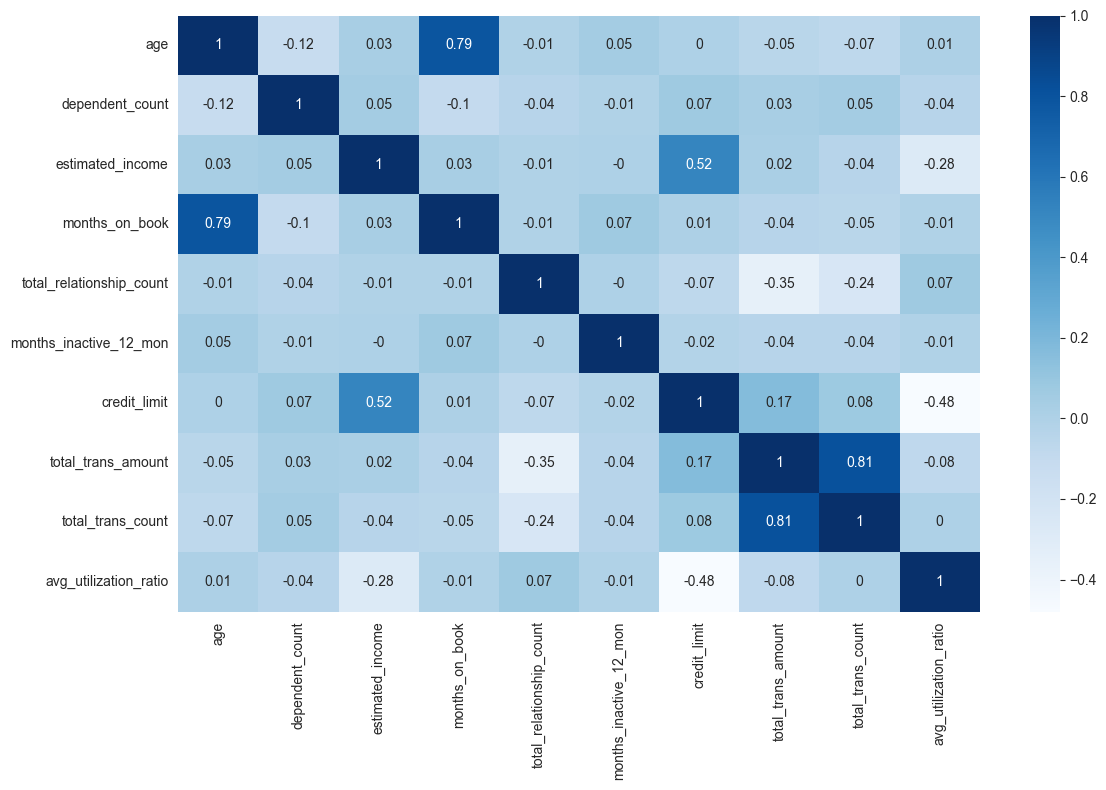

In [30]:
numeric_data = customers.drop('customer_id', axis=1).select_dtypes(include='number')

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(round(numeric_data.corr(), 2), cmap='Blues', annot=True, ax=ax)

plt.tight_layout()
plt.show()

Большинство переменных слабо коррелируют друг с другом, но есть некоторые, которые мы можем выделить:

* Возраст сильно коррелирует с тем, как долго человек является клиентом (months_on_book);
* Кредитный лимит положительно коррелирует с предполагаемым доходом и отрицательно коррелирует со средним коэффициентом использования;
* Общее количество транзакций (total_trans_count) сильно коррелирует с общей переведенной суммой (total_trans_amount).

<Figure size 1200x1000 with 0 Axes>

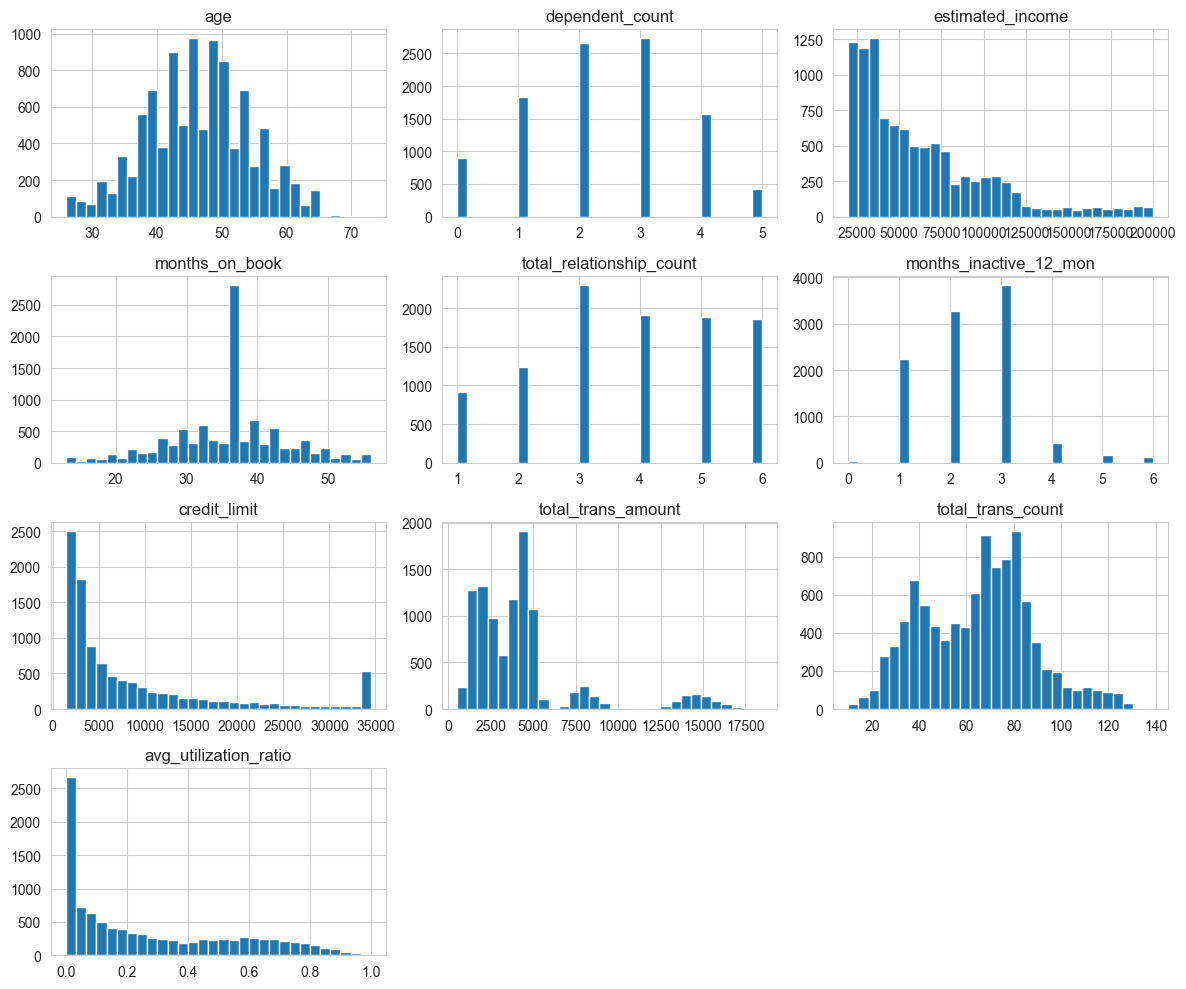

In [31]:
plt.figure(figsize=(12, 10))

customers.drop('customer_id', axis=1).hist(bins=30, figsize=(12, 10))

plt.tight_layout()
plt.show()

Что касается распределений, то некоторые из них ближе к нормальному распределению, но большинство из них искажены.

# Преобработка данных

Теперь мы имеем дело с 3 категориальными переменными.

Столбец `gender` самый простой. Мы используем лямбда-функцию, чтобы заменить значения единицами и нулями.

Мы также сможем преобразовать столбец `education_level` в числовой. Мы используем метод `replace()` для выполнения этой задачи. Этот метод назначит значение каждому уровню образования:

* `Uneducated - 0`
* `High School - 1`
* `College - 2`
* `Graduate - 3`
* `Post-Graduate - 4`
* `Doctorate - 5`

К сожалению, мы не можем сделать то же самое для столбца marital_status, поскольку, например, нет уровня величины между "Single", "Married" или "Divorced". Мы не можем сказать, что какой-либо из них выше или лучше других. Поэтому мы воспользуемся методом прямого кодирования, чтобы создать фиктивные переменные из этого столбца, а затем удалим исходную переменную.

In [32]:
customers_modif = customers.copy()
customers_modif['gender'] = customers['gender'].apply(lambda x: 1 if x == 'M' else 0)
customers_modif.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,1,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,0,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,1,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,0,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,1,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [33]:
customers_modif = customers_modif.replace({
    'Uneducated': 0, 'High School': 1, 'College': 2,
    'Graduate': 3, 'Post-Graduate': 4, 'Doctorate': 5
}).infer_objects(copy=False)

customers_modif['education_level'].head()

C:\Users\Dmitriy\AppData\Local\Temp\ipykernel_28064\1320842575.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customers_modif = customers_modif.replace({


0    1
1    3
2    3
3    1
4    0
Name: education_level, dtype: int64

In [34]:
dummies = pd.get_dummies(customers_modif[['marital_status']], drop_first=True)

customers_modif = pd.concat([customers_modif, dummies], axis=1)
customers_modif.drop(['marital_status'], axis=1, inplace=True)

print(customers_modif.shape)
customers_modif.head()

(10127, 16)


,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,True,False,False
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,False,True,False
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,True,False,False
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,False,False,True
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,True,False,False


# Стандартизация данных

Сначала нам нужно стандартизировать набор данных. Для этой задачи мы будем использовать StandardScaler() из scikit-learn.

In [35]:
X = customers_modif.drop('customer_id', axis=1)

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled[:5]

array([[-0.16540558,  1.05995565,  0.50336813, -0.75221102,  0.1758098 ,
         0.38462088,  0.76394261, -1.32713603,  0.4466219 , -0.95970657,
        -0.97389518, -0.77588223,  1.07733799, -0.79850685, -0.28260887],
       [ 0.33357038, -0.9434357 ,  2.04319867,  0.66278684, -0.96716585,
         1.01071482,  1.40730617, -1.32713603, -0.04136665, -0.91643261,
        -1.35734038, -0.61627565, -0.92821381,  1.2523374 , -0.28260887],
       [ 0.58305837,  1.05995565,  0.50336813,  0.66278684,  0.78539682,
         0.00896451,  0.12057905, -1.32713603, -0.5736978 , -0.74098169,
        -1.91120566, -0.99715499,  1.07733799, -0.79850685, -0.28260887],
       [-0.78912553, -0.9434357 ,  1.2732834 , -0.75221102, -0.63697289,
        -0.24147306, -0.52278451,  1.64147829, -0.58525108, -0.95175829,
        -1.91120566,  1.75968594, -0.92821381, -0.79850685,  3.53845931],
       [-0.78912553,  1.05995565,  0.50336813, -1.45970995,  0.07421197,
        -1.86931731,  0.76394261, -1.32713603, 

# Выбор K

Пришло время определиться с количеством кластеров. Мы запустим алгоритм k-средних, рассматривая диапазон от 1 до 10 возможных K, и сохраним результаты. Затем мы построим кривую локтя, которая поможет нам найти окончательный K.

C:\Users\Dmitriy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Dmitriy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.P

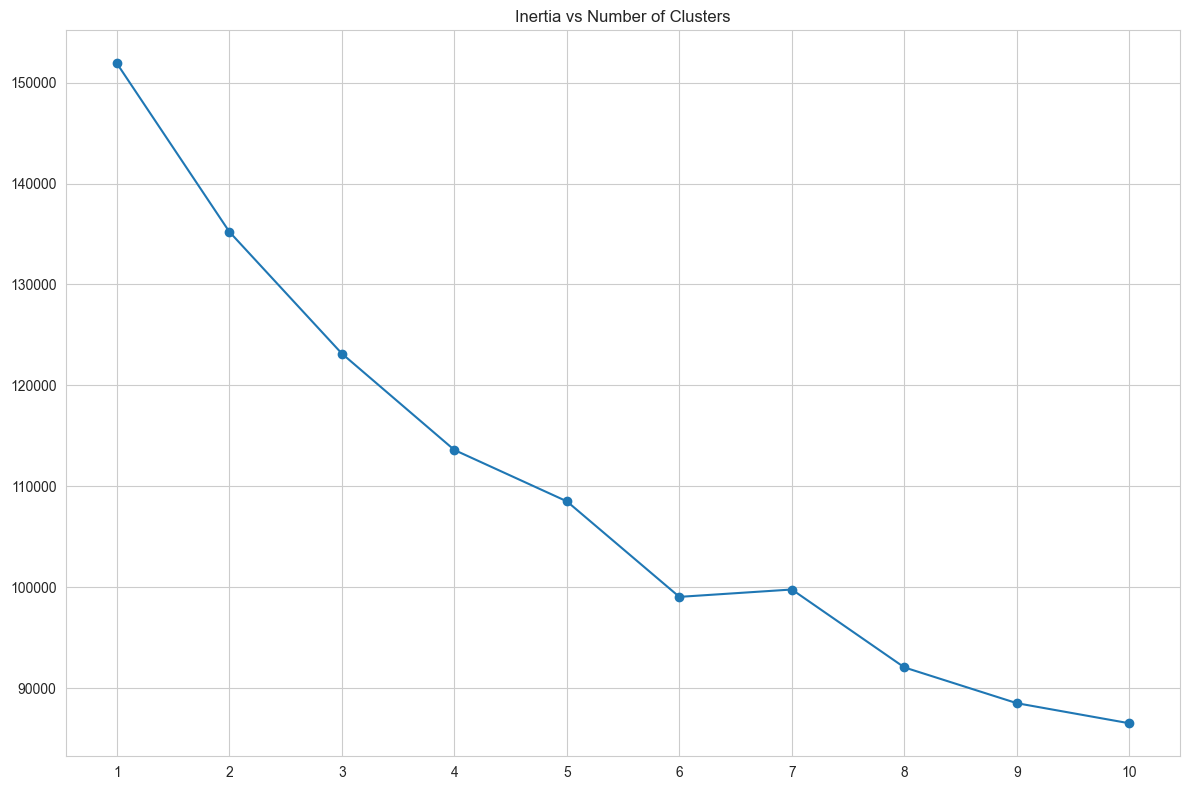

In [36]:
X = pd.DataFrame(X_scaled)
inertias = []

for k in range(1, 11):
    model = KMeans(n_clusters=k)
    y = model.fit_predict(X)
    inertias.append(model.inertia_)
    
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Inertia vs Number of Clusters')

plt.tight_layout()
plt.show()

Похоже, что скорость уменьшения инерции замедляется между 5 и 7 кластерами. Для дальнейшего движения будем использовать 6 кластеров.

In [37]:
model = KMeans(n_clusters=6)
y = model.fit_predict(X_scaled)

y

array([2, 0, 2, ..., 5, 3, 5], dtype=int32)

# Анализ результатов

Теперь давайте создадим столбец `CLUSTER` в нашем исходном наборе данных, чтобы лучше понять характеристики каждого из них.

In [39]:
customers['CLUSTER'] = y + 1
customers

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,CLUSTER
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,3
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,1
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,3
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,4
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,M,2,Graduate,Single,51000,40,3,2,4003.0,15476,117,0.462,1
10123,710638233,41,M,2,Graduate,Divorced,40000,25,4,2,4277.0,8764,69,0.511,2
10124,716506083,44,F,1,High School,Married,33000,36,5,3,5409.0,10291,60,0.000,6
10125,717406983,30,M,2,Graduate,Unknown,47000,36,4,3,5281.0,8395,62,0.000,4


In [40]:
customers['CLUSTER'].value_counts()

CLUSTER
6    2690
2    1958
5    1590
3    1590
1    1551
4     748
Name: count, dtype: int64

Мы видим, что кластер 6 является самым большим, а кластер 4 — самым маленьким.

Рассматривая только числовую переменную, мы проверим среднее значение каждой переменной на кластер. Нам просто нужно сгруппировать данные и построить столбчатую диаграмму для каждого столбца.

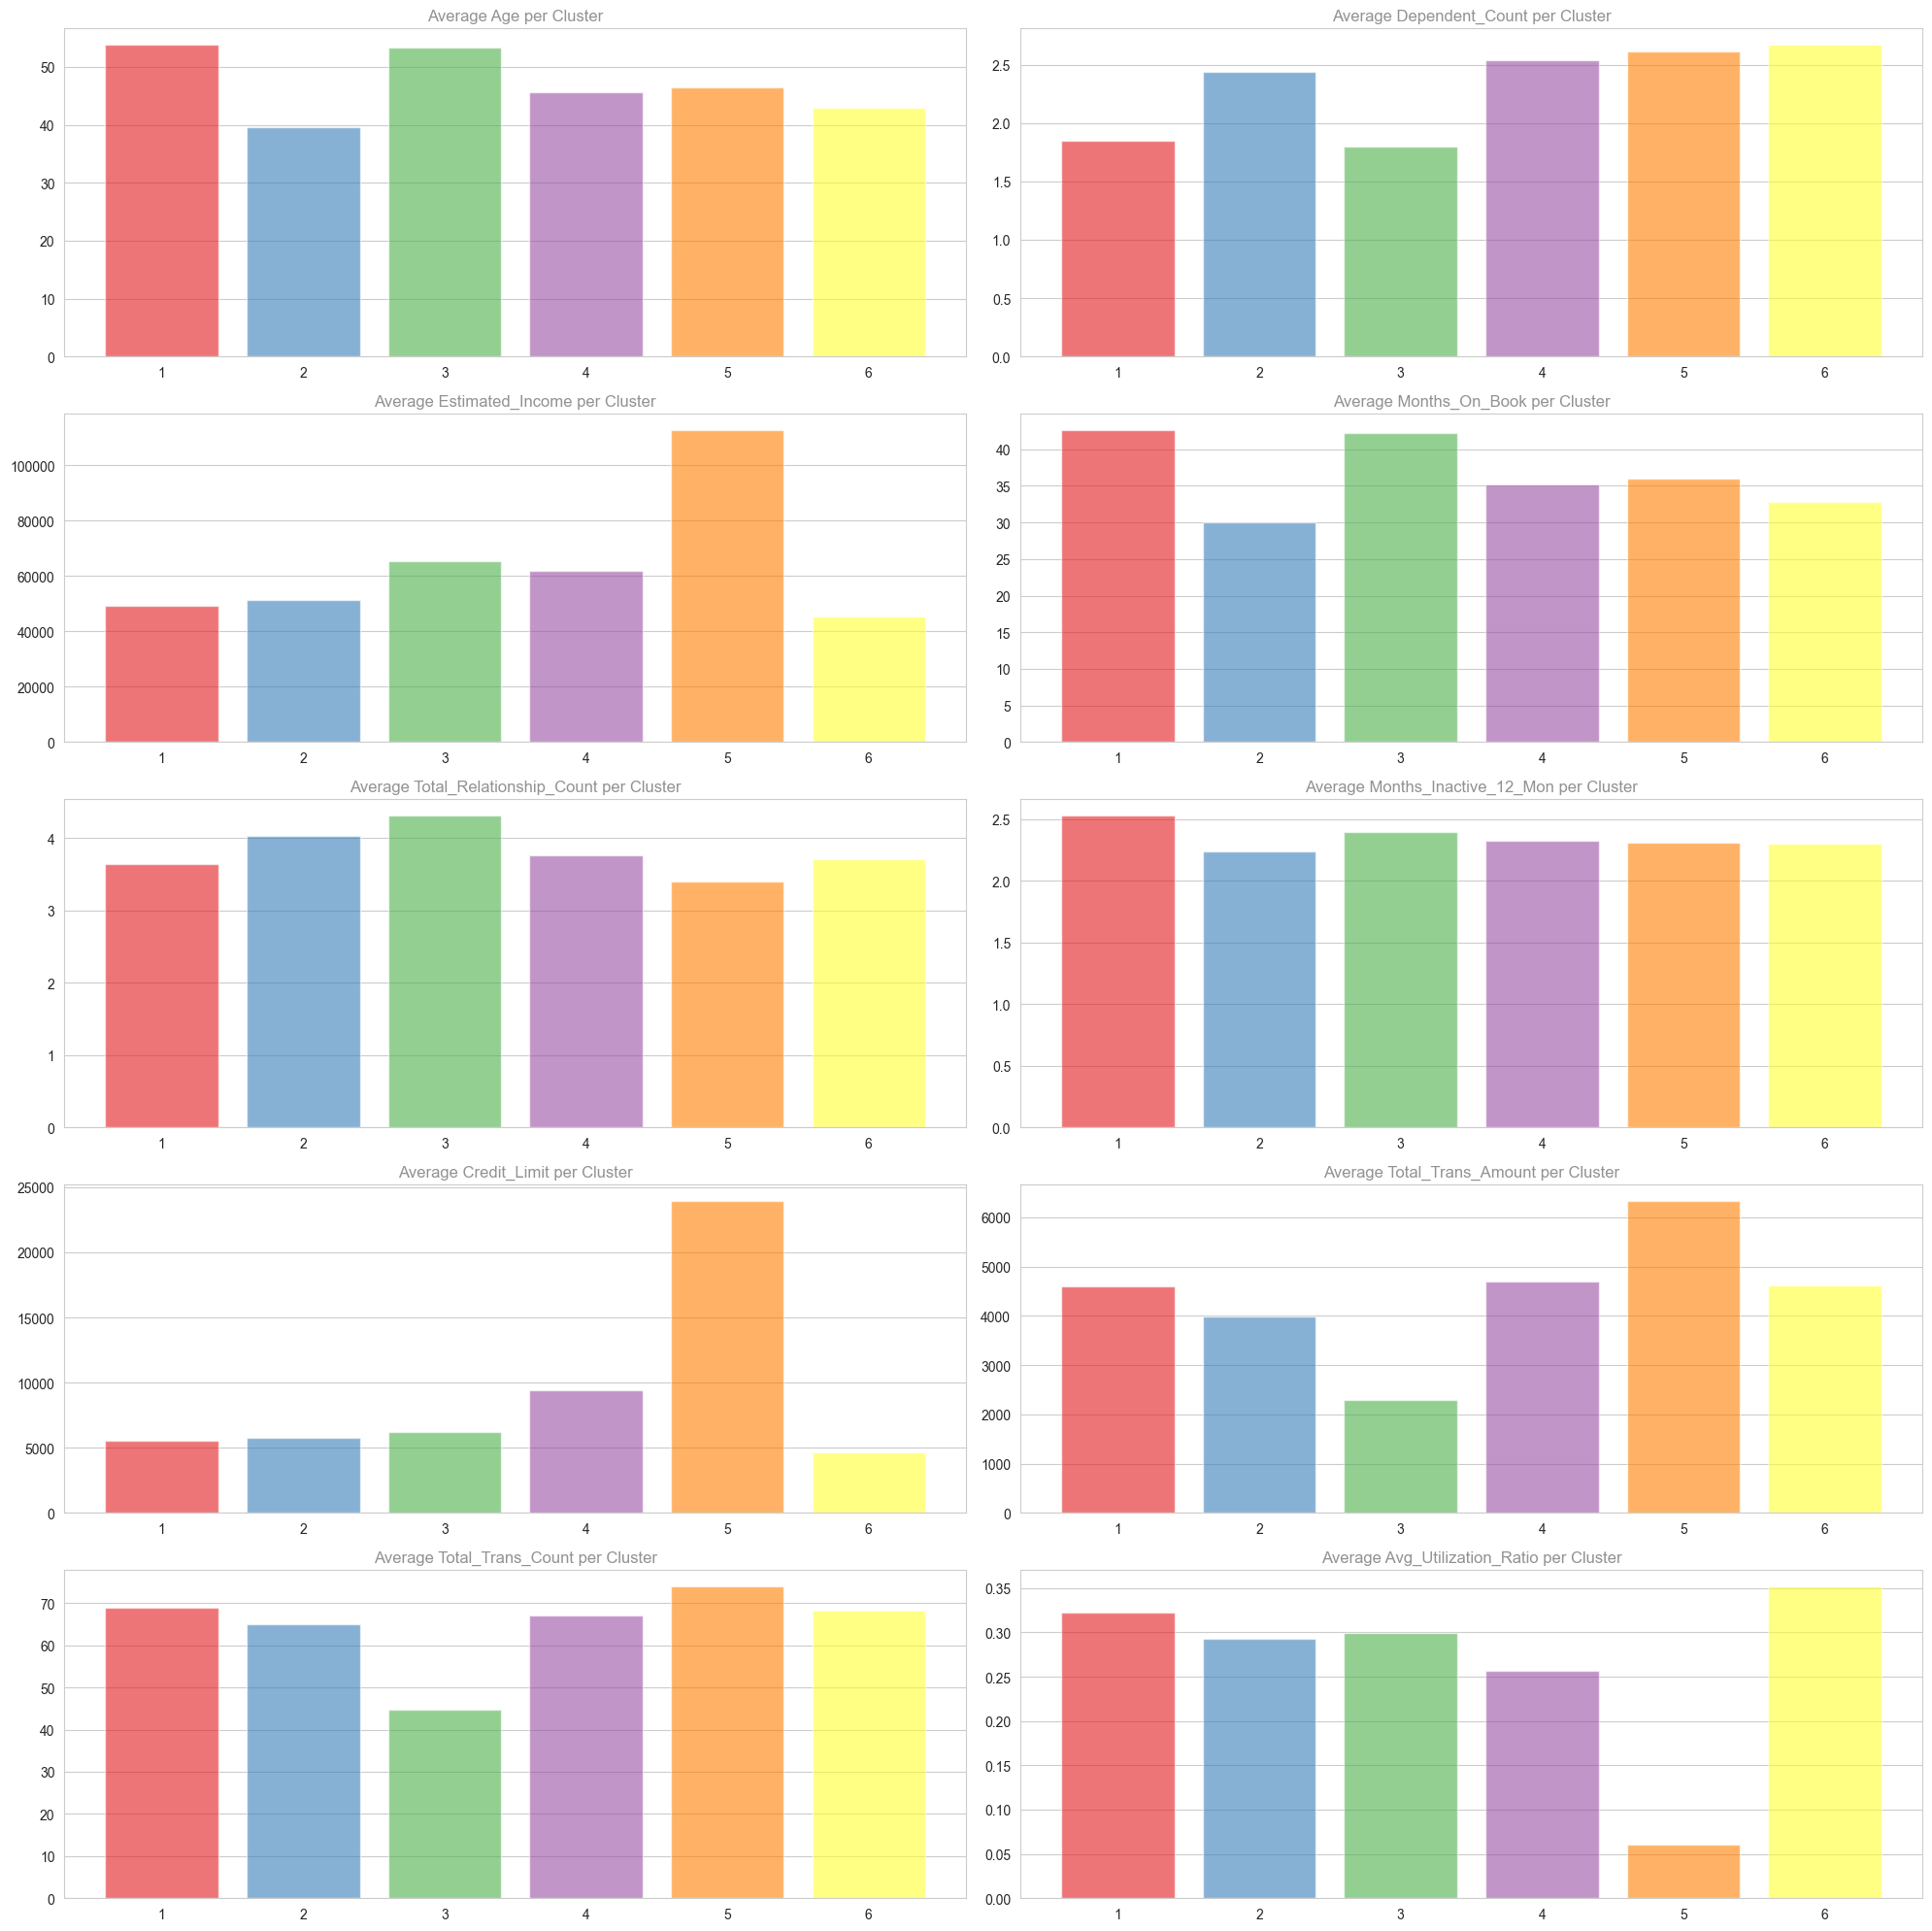

In [41]:
numeric_columns = customers.select_dtypes(include=np.number).drop(['customer_id', 'CLUSTER'], axis=1).columns

fig = plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_columns):
    df_plot = customers.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(5, 2, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()

Для числовых переменных с более высокой корреляцией, которые мы рассматривали ранее, мы также можем использовать диаграмму рассеяния, чтобы визуализировать эту корреляцию, сгруппированную по кластерам, и проанализировать, как кластеры изменяются между каждой областью диаграммы.

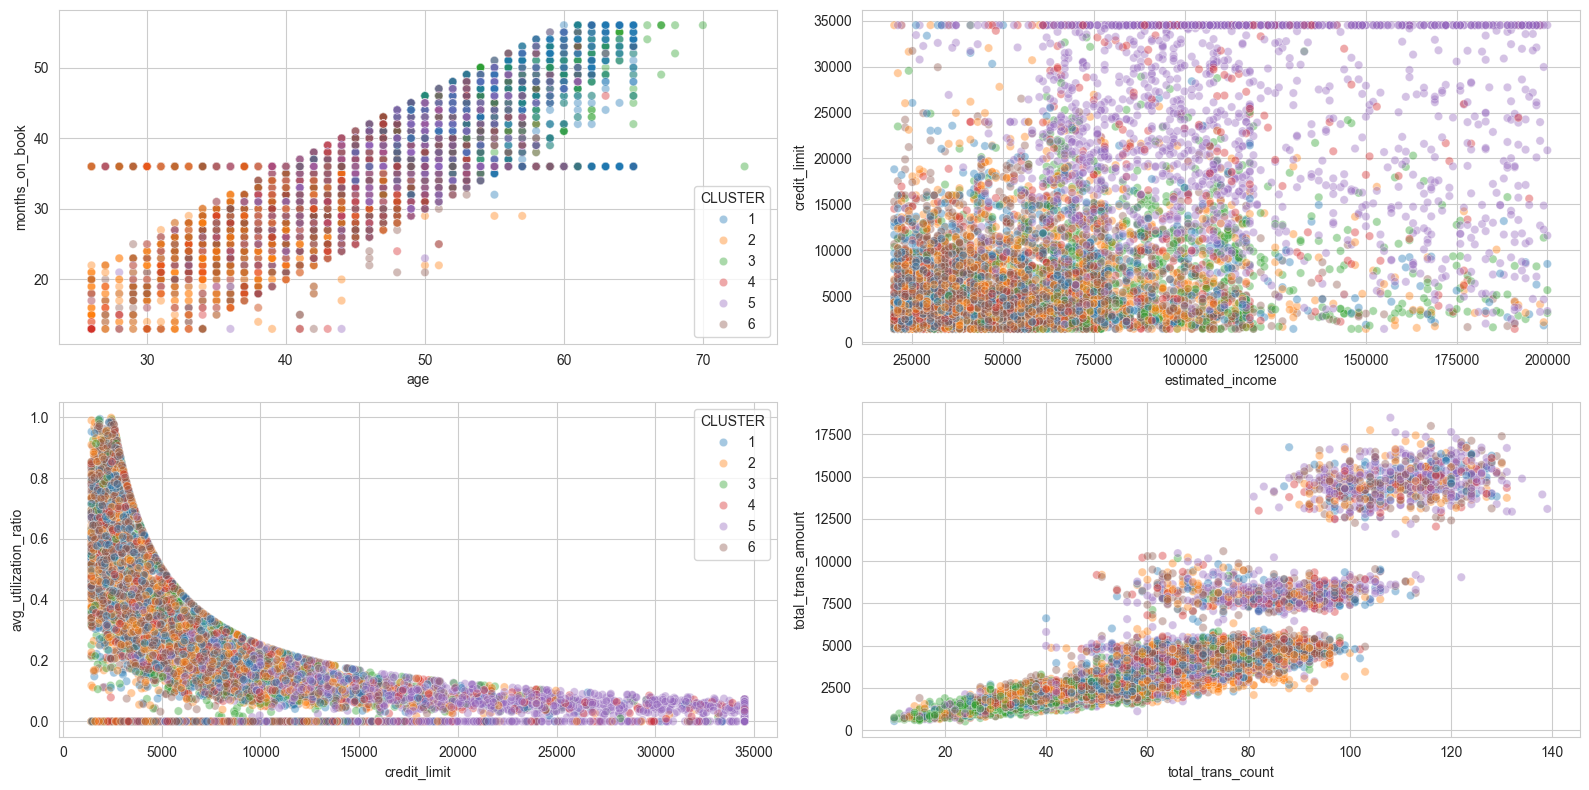

In [42]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax4, legend=False)

plt.tight_layout()
plt.show()

Мы можем сделать некоторые предварительные выводы, учитывая только числовые переменные.

Например, кластер 5 имеет самую большую сумму переведенных денег, в то время как кластер 2 имеет самый низкий кредитный лимит и предполагаемый доход и самый высокий коэффициент использования. Кластер 5 имеет самый высокий кредитный лимит. Клиенты старшего возраста сгруппированы в кластере 1.

Для категориальных столбцов мы построим процентное распределение каждой переменной в каждом кластере. Это позволит нам проверить, состоит ли конкретный кластер в основном из мужчин или только из женатых людей, например.

C:\Users\Dmitriy\AppData\Local\Temp\ipykernel_28064\906250918.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
C:\Users\Dmitriy\AppData\Local\Temp\ipykernel_28064\906250918.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
C:\Users\Dmitriy\AppData\Local\Temp\ipykernel_28064\906250918.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


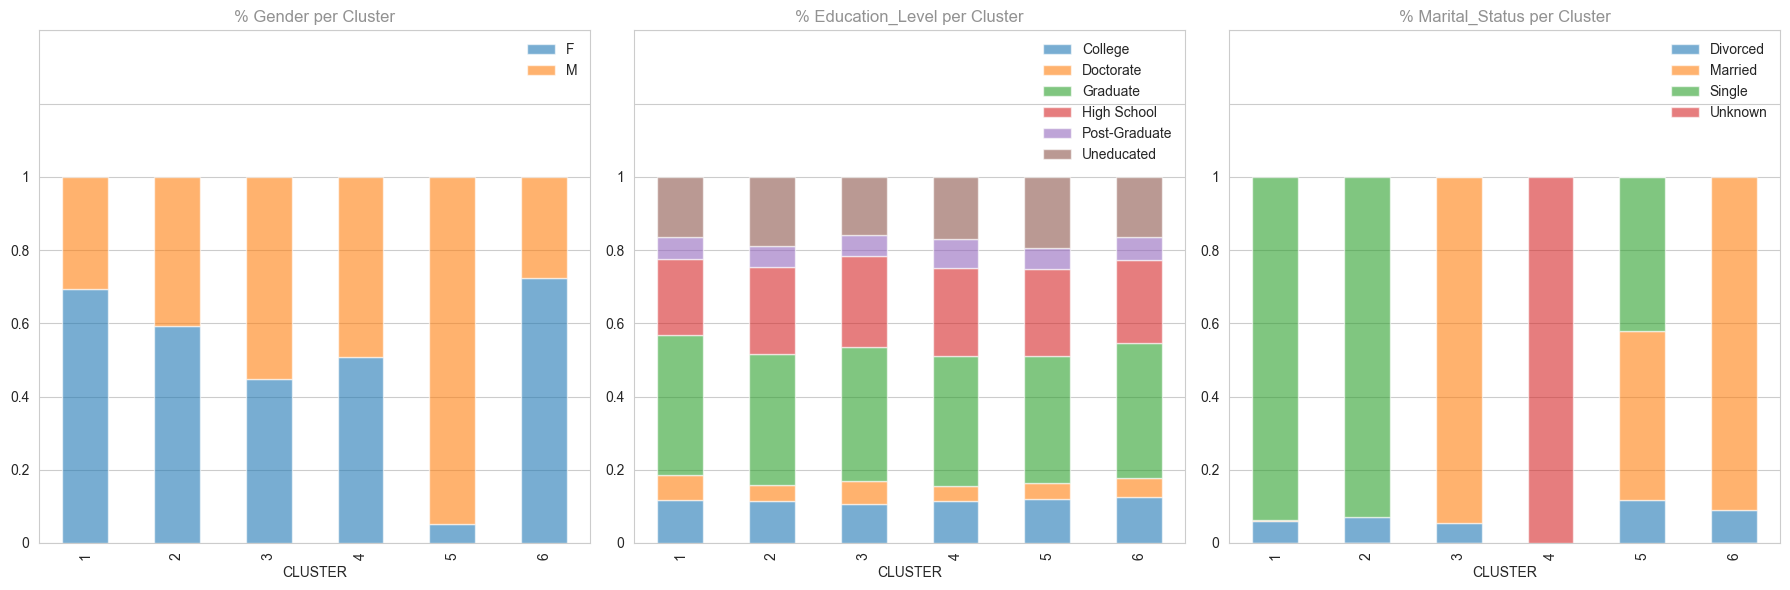

In [43]:
cat_columns = customers.select_dtypes(include=['object'])

fig = plt.figure(figsize=(18, 6))
for i, col in enumerate(cat_columns):
    plot_df = pd.crosstab(index=customers['CLUSTER'], columns=customers[col], values=customers[col], aggfunc='size', normalize='index')
    ax = fig.add_subplot(1, 3, i+1)
    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
    ax.set_title(f'% {col.title()} per Cluster', alpha=0.5)

    ax.set_ylim(0, 1.4)
    ax.legend(frameon=False)
    ax.xaxis.grid(False)
    
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax.set_yticklabels(labels)

plt.tight_layout()
plt.show()

Рассматривая категориальные переменные, мы замечаем, что уровень образования хорошо разделен между кластерами.

В других важных моментах, кластер 3,6 состоит почти полностью из женатых людей, в то время как мы не знаем семейного положения никого в кластере 4. Кластер 5 почти полностью состоит из мужчин, а кластер 1,2 на 95% состоит из одиноких людей.

# Анализ Кластеров Клиентов
---

### **Кластер 1**
- **Пол**: Преобладают женщины  
- **Семейное положение**: В основном одинокие  
- **Образование**: В основном College и Graduate  
- **Финансы**: Средний доход и кредитный лимит  
- **Активность**: Среднее количество транзакций

**Инсайт**: Самостоятельные женщины со стабильным доходом. Подходят премиальные предложения или скидки на технологии и путешествия.

---

### **Кластер 2**
- **Пол**: Баланс мужчин и женщин  
- **Семейное положение**: В основном одинокие  
- **Образование**: Низкий уровень (много необразованных)  
- **Финансы**: Низкий доход и кредитный лимит  
- **Активность**: Средний уровень использования карты

📌 **Инсайт**: Молодые или только начавшие работать клиенты. Рекомендуются программы по финансовой грамотности и бонусы на повседневные траты.

---

### **Кластер 3**
- **Пол**: Баланс мужчин и женщин   
- **Семейное положение**: В основном замужние  
- **Образование**: Высокий уровень  
- **Финансы**: Высокий доход и кредитный лимит  
- **Активность**: Умеренное использование карты

📌 **Инсайт**: Финансово стабильные клиенты. Подходят инвестиционные продукты и премиальные карты.

---

### **Кластер 4**
- **Пол**:  Баланс мужчин и женщин  
- **Семейное положение**: Разнообразное  
- **Образование**: Высокий уровень  
- **Финансы**: Высокий доход и лимит  
- **Активность**: Низкий уровень использования

📌 **Инсайт**: Потенциальные VIP-клиенты, которых можно активизировать предложениями с кэшбэками и бонусами.

---

### **Кластер 5**
- **Пол**: В основном мужчины  
- **Возраст**: Пожилые  
- **Семейное положение**: Замужние/одинокие  
- **Образование**: Средний уровень  
- **Финансы**: Низкий доход и лимит  
- **Активность**: Частое использование карты

📌 **Инсайт**: Лояльные клиенты, используют карту для повседневных нужд. Подходят программы лояльности и скидки на товары первой необходимости.

---

### **Кластер 6**
- **Пол**: В основном женщины 
- **Семейное положение**: В основном женатые  
- **Образование**: Средний уровень  
- **Финансы**: Низкий кредитный лимит  
- **Активность**: Частое использование карты

📌 **Инсайт**: Активные пользователи с ограниченными возможностями. Можно предложить увеличение лимита или рассрочку на категории покупок.

---

In [44]:
# List of customers and clusters
customers[['customer_id', 'CLUSTER']]

,customer_id,CLUSTER
0,768805383,3
1,818770008,1
2,713982108,3
3,769911858,4
4,709106358,6
...,...,...
10122,772366833,1
10123,710638233,2
10124,716506083,6
10125,717406983,4
